## 实验：权重衰减

解决过拟合问题的一种常用方法：权重衰减

权重衰减等价于 $L_2$ 范数正则化（**Regularization**）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。我们先描述 $L_2$ 范数正则化，再解释它为何又称权重衰减。

$L_2$ 范数正则化在模型原损失函数基础上添加 $L_2$ 范数惩罚项，从而得到训练所需要最小化的函数。$L_2$ 范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。以线性回归损失函数

$$\ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2$$

为例，其中 $w_1, w_2$ 是权重参数，$b$ 是偏差参数，样本 $i$ 的输入为 $x_1^{(i)}, x_2^{(i)}$，标签为 $y^{(i)}$，样本数为 $n$。将权重参数用向量 $\boldsymbol{w} = [w_1, w_2]$ 表示，带有 $L_2$ 范数惩罚项的新损失函数为

$$\ell(w_1, w_2, b) + \frac{\lambda}{2} |\boldsymbol{w}|^2,$$

其中超参数 $\lambda > 0$。当权重参数均为 0 时，惩罚项最小。当 $\lambda$ 较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当 $\lambda$ 设为 0 时，惩罚项完全不起作用。上式中 $L_2$ 范数平方 $|\boldsymbol{w}|^2$ 展开后得到 $w_1^2 + w_2^2$。有了 $L_2$ 范数惩罚项后，在小批量随机梯度下降中，将“线性回归”一节中权重 $w_1$ 和 $w_2$ 的迭代方式更改为

$$w_1\leftarrow(1-\eta\lambda)w_1-\frac{\eta}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}x_1^{(i)}(x_1^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)})$$

$$w_2\leftarrow(1-\eta\lambda)w_2-\frac{\eta}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}x_2^{(i)}(x_1^{(i)}w_1+x_2^{(i)}w_2+b-y^{(i)})$$

可见，$L_2$ 范数正则化令权重 $w_1$ 和 $w_2$ 先自乘小于 1 的数，再减去不含惩罚项的梯度。因此，$L_2$ 范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平方和。

### 实验目标：

在本高维线性回归实验中，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为 $p$。对于训练数据集和测试数据集中特征为 $x_1, x_2, \ldots, x_p$ 的任一样本，我们使用如下的线性函数来生成该样本的标签：

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i + \epsilon,$$

其中噪声项 $\epsilon$ 服从均值为 0、标准差为 0.01 的正态分布。

为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度 $p=200$；同时，我们特意把训练数据集的样本数设低，如 `20`。

### 1. 导入库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras import optimizers, regularizers

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05

features = tf.random.normal(shape=(n_train + n_test, num_inputs))

labels = tf.keras.backend.dot(features, true_w) + true_b
labels += tf.random.normal(mean=0.01, shape=labels.shape)

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

下面，我们通过在目标函数后添加 $L2$ 范数惩罚项来实现权重衰减。

### 1. 初始化模型参数

#### 1.1 定义随机初始化模型参数的函数

首先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度。

In [2]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w, b]

#### 1.2 定义线性回归函数

In [3]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

#### 1.3 定义平方损失函数

In [4]:
def squared_loss(y_hat, y): 
    # 注意这里返回的是向量
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

#### 1.4 定义随机梯度下降函数

In [5]:
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

#### 1.5 定义损失值绘制函数

In [6]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

#### 1.6 定义图形参数

将显示图形设置为 SVG 格式

In [7]:
from IPython import display
def use_svg_display():
    """以 svg 格式在 jupyter notebook 中显示图形"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置 Matplotlib 图形尺寸"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

### 2. 定义 $L_2$ 范数惩罚项

下面定义 $L_2$ 范数惩罚项。这里指惩罚模型的权重参数，实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [8]:
def l2_penalty(w):
    return tf.reduce_sum((w**2)) / 2

### 3. 定义训练和测试代码

下面定义如何在训练数据集和测试数据集上分别训练和测试模型。这里在计算最终的损失函数时添加了 $L_2$ 范数惩罚项。

In [9]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, squared_loss
optimizer = tf.keras.optimizers.SGD()
train_iter = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)).batch(batch_size).shuffle(batch_size)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape(persistent=True) as tape:
                
                # 添加了L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            sgd([w, b], lr, batch_size, grads)
        
        train_ls.append(tf.reduce_mean(loss(net(train_features, w, b),
                        train_labels)).numpy())
        test_ls.append(tf.reduce_mean(loss(net(test_features, w, b),
                        test_labels)).numpy())
    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    
    print('L2 norm of w:', tf.norm(w).numpy())

### 4. 观察过拟合

接下来，让我们忽略正则化，直接训练训练并测试高维线性回归模型。

当 `lambd` 设为 `0` 时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。

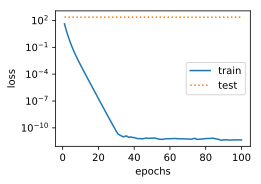

L2 norm of w: 19.915857


In [10]:
fit_and_plot(lambd=0)

### 5. 使用权重衰减

下面我们使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的 $L_2$ 范数比不使用权重衰减时的更小，此时的权重参数更接近 0。

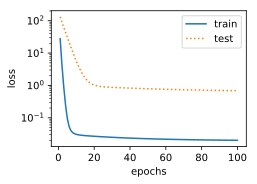

L2 norm of w: 0.2555388


In [11]:
fit_and_plot(lambd=3)

### 6. 在 Tensorflow 上进行权重衰减

在 TensorFlow2.0 中，我们可以对 Dense 层传入 `kernel_regularizer` 参数进行权重衰减。详细参数设置请[查阅官方文档](https://keras.io/api/layers/regularizers/)。

In [12]:
def fit_and_plot_tf2(wd, lr=1e-3):
    model = tf.keras.models.Sequential()
    
    # 对 Dense 层传入 kernel_regularizer 参数进行权重衰减
    model.add(tf.keras.layers.Dense(1, 
                                 kernel_regularizer=regularizers.l2(wd), 
                                 bias_regularizer=None))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), 
                 loss=tf.keras.losses.MeanSquaredError())
    
    history = model.fit(train_features, train_labels, epochs=100, batch_size=1, 
              validation_data=(test_features, test_labels),
              validation_freq=1,verbose=0)
    
    train_ls = history.history['loss']
    test_ls = history.history['val_loss']
    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    
    print('L2 norm of w:', tf.norm(model.get_weights()[0]).numpy())

与从零开始实现权重衰减的实验现象类似，使用权重衰减可以在一定程度上缓解过拟合问题。

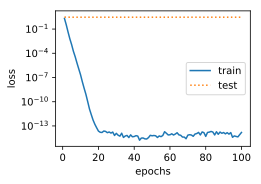

L2 norm of w: 1.3538781


In [13]:
fit_and_plot_tf2(0, lr)

使用权重衰减：

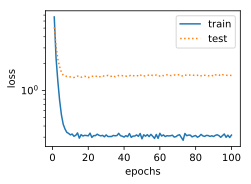

L2 norm of w: 0.27053905


In [14]:
fit_and_plot_tf2(3, lr)

### 实验小结

在本实验中，你分别通过 Python 和 Tensorflow 实现了在神经网络中测试权重衰减对过拟合现象的缓和作用。通过本实验，你应该能了解到：

- 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
- 权重衰减等价于 $L_2$ 范数正则化，通常会使学到的权重参数的元素较接近 0。
- 权重衰减可以通过 `kernel_regularizer` 超参数来指定。
- 可以定义多个优化器实例，对不同的模型参数使用不同的迭代方法。